# Advanced Lane Finding
### Import Libraries


In [1]:
# Import lobraries
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Find Camera Calibration Parameters

In [2]:
def get_camera_calibration_mtx_dist():
    # Number of rows and columns of checkerboard corners
    nx = 9
    ny = 6
    objPoints = []
    imgPoints = []
    
    # Create object points
    objP = np.zeros((nx*ny,3), np.float32)
    objP[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    fpaths = glob.glob('./camera_cal/calibration*.jpg')
    
    for fpath in fpaths:
        image = mpimg.imread(fpath)
        grayed= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # RGB input due to mpimg use

        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(grayed, (nx,ny), None)

        if ret:
            objPoints.append(objP)
            imgPoints.append(corners)
    
    # Do camera calibraiton given the object points and image points
    image_size = (grayed.shape[1], grayed.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, image_size, None, None)
    
    return (mtx, dist)

### Undistort Image using Calibration Matrix

In [3]:
# Get Camera Calibration Parameters
mtx, dist = get_camera_calibration_mtx_dist();
before_undist = mpimg.imread('./camera_cal/calibration1.jpg')
before_undist = mpimg.imread('./test_images/test1.jpg')
after_undist  = cv2.undistort(before_undist, mtx, dist, None, mtx)

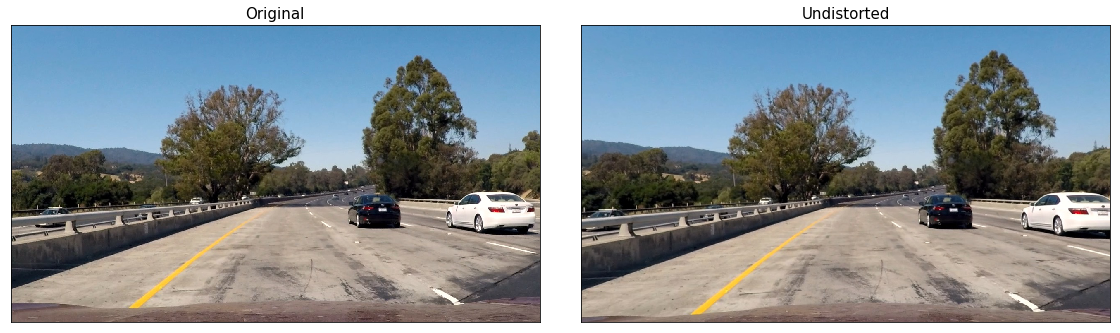

In [4]:
# Visualize raw image and processed image
def visualize_processed_image(before, after, bTitle='Before', aTitle='After'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.tight_layout()
    
    ax1.imshow(before)
    ax1.set_title(bTitle, fontsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([])


    ax2.imshow(after)
    ax2.set_title(aTitle, fontsize=15)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    plt.savefig("./output_images/image.png", transparent = False, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    
visualize_processed_image(before_undist, after_undist, bTitle='Original', aTitle='Undistorted')

### Filter Input Image

In [5]:
# Gradient Magnitude Threshold based Filter
def grad_mag_filter(image, ksize=3, threshold=(50, 200)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # RGB input due to mpimg use

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize and scale to 0-255 and take 8bit integer
    scaled_mag = np.uint8( (grad_mag/np.max(grad_mag))*255 )
    
    binary = np.zeros_like(scaled_mag)
    binary[ (scaled_mag >= threshold[0]) & (scaled_mag <= threshold[1]) ] = 1
    
    return binary


# Gradient Direction Threshold based Filter (threshold in radians)
def grad_dir_filter(image, ksize=3, threshold=([np.deg2rad(45), np.deg2rad(75)])):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # RGB input due to mpimg use
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    directions  = np.arctan2(abs_sobely, abs_sobelx)
    
    binary = np.zeros_like(directions)
    binary[ (directions >= threshold[0]) & (directions <= threshold[1]) ] = 1
    
    return binary

# Filter HLS image based on S (saturation) threshold
def s_channel_filter(image, threshold=(90, 255)):
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    s_channel = hls_image[:, :, 2]
    
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= threshold[0]) & (s_channel <= threshold[1]) ] = 1
    
    return binary

# Filter HLS image based on L (lightness) threshold
def l_channel_filter(image, threshold=(210, 255)):
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    l_channel = hls_image[:, :, 1]
    
    binary = np.zeros_like(l_channel)
    binary[(l_channel >= threshold[0]) & (l_channel <= threshold[1]) ] = 1
    
    return binary

# Filter Lab image based on b (blue-yellow) threshold
def b_channel_filter(image, threshold=(145, 255)):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    b_channel = lab_image[:, :, 2]
    
    binary = np.zeros_like(b_channel)
    binary[(b_channel >= threshold[0]) & (b_channel <= threshold[1]) ] = 1
    
    return binary

In [6]:
def filter_image(image, show_results=False):
    grad_mag_filtered = grad_mag_filter(image, ksize=3, threshold=(50,200))
    grad_dir_filtered = grad_dir_filter(image, ksize=3, threshold=(np.deg2rad(40), np.deg2rad(75)))    
    s_channel_filtered= s_channel_filter(image, threshold=(170, 255))
    l_channel_filtered= l_channel_filter(image, threshold=(210, 255))
    b_channel_filtered= b_channel_filter(image, threshold=(145, 255))
    
    if show_results:
        visualize_processed_image(image, grad_mag_filtered, bTitle='Original', aTitle='Gradient Mag Filtered')
        visualize_processed_image(image, s_channel_filtered, bTitle='Original', aTitle='Saturation Filtered')
        visualize_processed_image(image, l_channel_filtered, bTitle='Original', aTitle='lightness Filtered')
        visualize_processed_image(image, b_channel_filtered, bTitle='Original', aTitle='Blue-Yellow Filtered')
    
    output = np.zeros_like(b_channel_filtered)
    output[ (grad_mag_filtered == 1) | ((s_channel_filtered == 1) | (l_channel_filtered == 1) | (b_channel_filtered == 1)) ] = 1
    
    return output


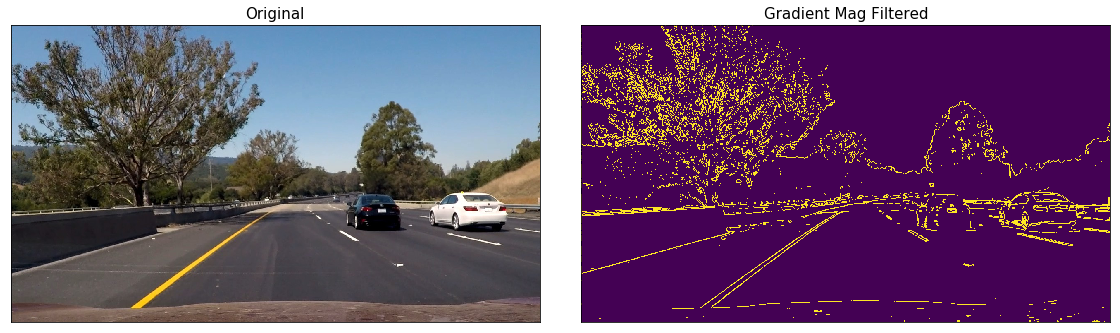

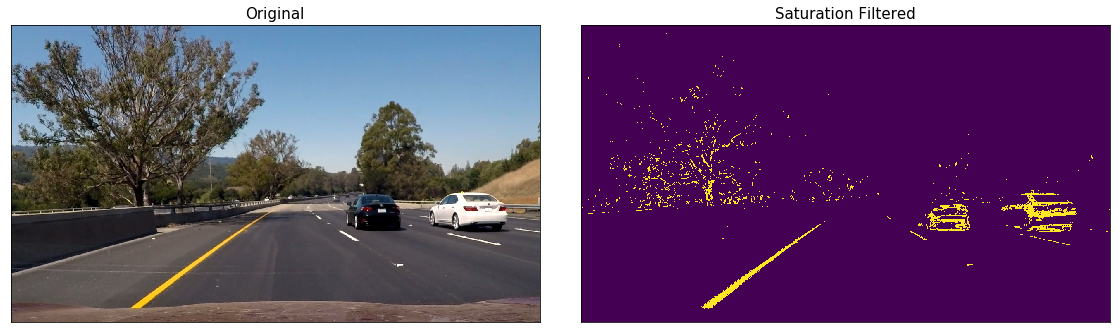

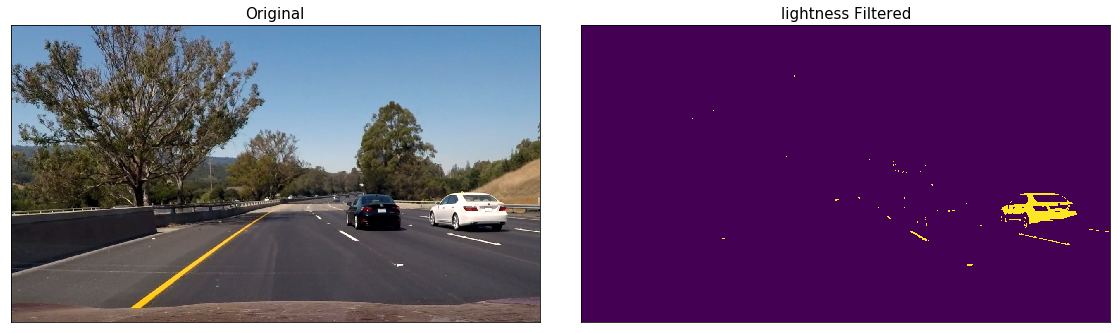

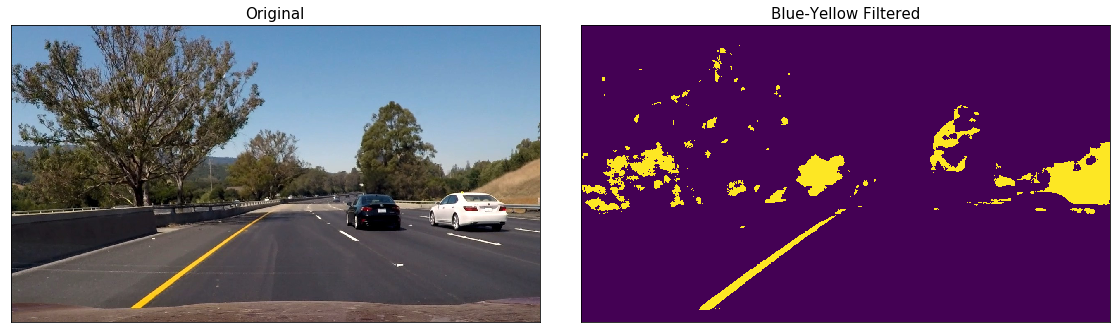

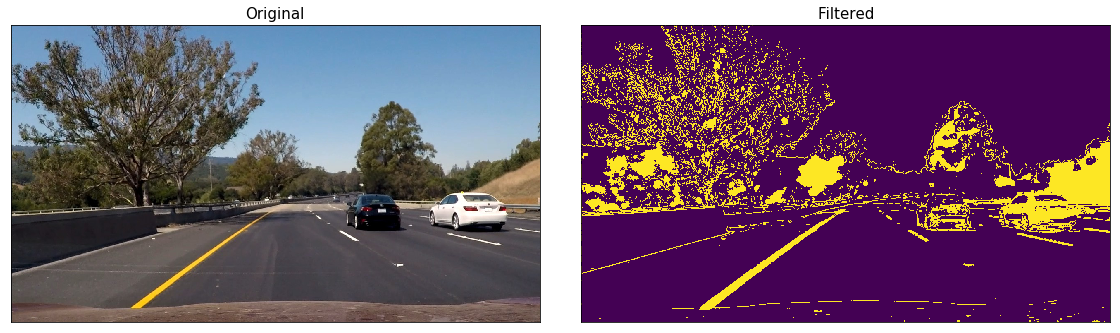

In [7]:
before_filter = mpimg.imread('./test_images/test6.jpg')
after_filter  = filter_image(before_filter, show_results=True)

visualize_processed_image(before_filter, after_filter, bTitle='Original', aTitle='Filtered')

### Perspective Transform using Affine Transformation

In [8]:
def warp_image(image, draw_line=False, reverse=False):
    image_shape = (image.shape[1], image.shape[0])
    
    s_left_b = [ (image_shape[0] * (1/6))-10, (image_shape[1] * (1/1))     ]
    s_left_t = [ (image_shape[0] * (1/2))-58, (image_shape[1] * (1/2))+100 ] 
    s_right_t= [ (image_shape[0] * (1/2))+62, (image_shape[1] * (1/2))+100 ]
    s_right_b= [ (image_shape[0] * (5/6))+42, (image_shape[1] * (1/1))     ]
    
    d_left_b = [ (image_shape[0] * (1/4)), (image_shape[1] * (1/1)) ]
    d_left_t = [ (image_shape[0] * (1/4)), (image_shape[1] * (0/1)) ] 
    d_right_t= [ (image_shape[0] * (3/4)), (image_shape[1] * (0/1)) ]
    d_right_b= [ (image_shape[0] * (3/4)), (image_shape[1] * (1/1)) ]
    
    src = [ s_left_b, s_left_t, s_right_t, s_right_b ]
    dst = [ d_left_b, d_left_t, d_right_t, d_right_b ]
    
    src = np.array(src, np.float32)
    dst = np.array(dst, np.float32)
    
    if reverse==False:
        M = cv2.getPerspectiveTransform(src, dst)    
        output = cv2.warpPerspective(image, M, image_shape, flags=cv2.INTER_LINEAR)
    else:
        Minv = cv2.getPerspectiveTransform(dst, src)    
        output = cv2.warpPerspective(image, Minv, image_shape, flags=cv2.INTER_LINEAR)
    
    if draw_line:
        line_color = (0,0,250)
        cv2.line(image, tuple(src[0]), tuple(src[1]), line_color, 2 )
        cv2.line(image, tuple(src[2]), tuple(src[3]), line_color, 2 )
        
        cv2.line(output, tuple(dst[0]), tuple(dst[1]), line_color, 2 )
        cv2.line(output, tuple(dst[2]), tuple(dst[3]), line_color, 2 )
        
    return image, output
    

#### Tune Perspective Transform Matrix

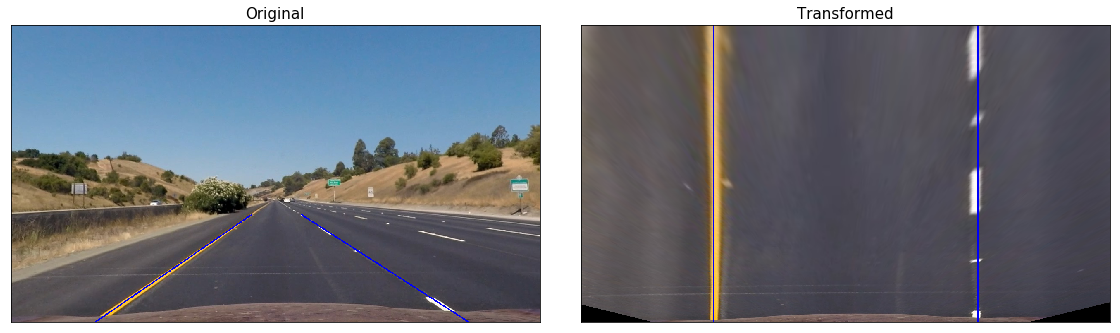

In [9]:
original    = mpimg.imread('./test_images/straight_lines1.jpg')
undistorted = cv2.undistort(original, mtx, dist, None, mtx)
before_warp, after_warp  = warp_image(undistorted, draw_line=True)

visualize_processed_image(before_warp, after_warp, bTitle='Original', aTitle='Transformed')

### Detect Lane Line

In [10]:
class Line():
    def __init__(self):
        self.curve = None
        self.coeff = None
        self.radius= None


class LaneTracker():
    def __init__(self):
        self.detected = False
        self.ploty = None
        self.left_line = Line()
        self.right_line = Line()
        
    
    
    def detectLanes(self, binary_warped):
        if self.detected:
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 30
            left_lane_inds = ((nonzerox > (self.left_line.coeff[0]*(nonzeroy**2) + self.left_line.coeff[1]*nonzeroy + self.left_line.coeff[2] - margin)) & (nonzerox < (self.left_line.coeff[0]*(nonzeroy**2) + self.left_line.coeff[1]*nonzeroy + self.left_line.coeff[2] + margin))) 
            right_lane_inds = ((nonzerox > (self.right_line.coeff[0]*(nonzeroy**2) + self.right_line.coeff[1]*nonzeroy + self.right_line.coeff[2] - margin)) & (nonzerox < (self.right_line.coeff[0]*(nonzeroy**2) + self.right_line.coeff[1]*nonzeroy + self.right_line.coeff[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            # Fit a second order polynomial to each
            self.left_line.coeff  = np.polyfit(lefty, leftx, 2)
            self.right_line.coeff = np.polyfit(righty, rightx, 2)
            
            # Generate x and y values for plotting
            self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            
            self.left_line.curve = self.left_line.coeff[0]*self.ploty**2 + self.left_line.coeff[1]*self.ploty + self.left_line.coeff[2]
            self.right_line.curve =  self.right_line.coeff[0]*self.ploty**2 + self.right_line.coeff[1]*self.ploty + self.right_line.coeff[2]

        else:
            
            # Take a histogram of the bottom half of the binary_warped image
            histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)

            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 12
            
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            
            # Set the width of the windows +/- margin
            margin = 30
            
            # Set minimum number of pixels found to recenter window
            minpix = 50
            
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
                
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            self.left_line.coeff  = np.polyfit(lefty, leftx, 2)
            self.right_line.coeff = np.polyfit(righty, rightx, 2)
            
            # Generate x and y values for plotting
            temp_ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            
            temp_l_curve = self.left_line.coeff[0]*temp_ploty**2 + self.left_line.coeff[1]*temp_ploty + self.left_line.coeff[2]
            temp_r_curve = self.right_line.coeff[0]*temp_ploty**2 + self.right_line.coeff[1]*temp_ploty + self.right_line.coeff[2]
          
            l_rad, r_rad = self.findCurvatureRadii(temp_ploty, temp_l_curve, temp_r_curve)
            self.detected = self.do_sanity_check(l_rad, r_rad)
            
            if (self.detected):
                # Generate x and y values for plotting
                self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
                self.left_line.curve  = self.left_line.coeff[0]*self.ploty**2 + self.left_line.coeff[1]*self.ploty + self.left_line.coeff[2]
                self.right_line.curve = self.right_line.coeff[0]*self.ploty**2 + self.right_line.coeff[1]*self.ploty + self.right_line.coeff[2]
        return
    
    
    # Find curvature of lines in real world
    def findCurvatureRadii(self, ploty, left_curve, right_curve):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720   # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_curve_scaled  = np.polyfit(ploty * ym_per_pix, left_curve * xm_per_pix, 2)
        right_curve_scaled = np.polyfit(ploty * ym_per_pix, right_curve * xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_radius = ((1 + (2 * left_curve_scaled[0] * np.max(ploty) * ym_per_pix + left_curve_scaled[1])**2)**1.5) / np.absolute(2 * left_curve_scaled[0])
        right_radius = ((1 + (2 * right_curve_scaled[0] * np.max(ploty) * ym_per_pix + right_curve_scaled[1])**2)**1.5) / np.absolute(2 * right_curve_scaled[0])

        # Now our radius of curvature is in meters
        return (left_radius, right_radius)
   

    # Do a simple sanity check
    def do_sanity_check(self, left_radius, right_radius):
        # curvature sanity check
        if (left_radius >= 200) & (right_radius >= 200):
            return True
        else:
            return False
                    

### Overlay Lane

In [11]:
def overlayLane(undist, warped, lanes):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lanes.left_line.curve , lanes.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lanes.right_line.curve, lanes.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    color_warp, newwarp  = warp_image(color_warp, draw_line=False, reverse=True)

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result
    

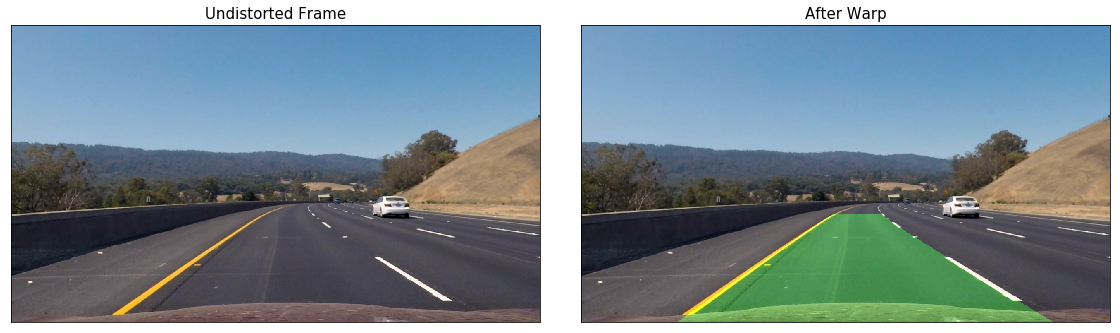

In [12]:
original    = mpimg.imread('./test_images/test3.jpg')
undistorted = cv2.undistort(original, mtx, dist, None, mtx)
filtered    = filter_image(undistorted, show_results=False)
before_warp, after_warp  = warp_image(filtered, draw_line=False)

lanes = LaneTracker()
lanes.detectLanes(after_warp)
histogram = np.sum(after_warp[np.int32(after_warp.shape[0]/2):,:], axis=0)
overlayed = overlayLane(undistorted, after_warp, lanes)

visualize_processed_image(undistorted, overlayed, bTitle='Undistorted Frame', aTitle='After Warp')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
# fig.tight_layout()
# ax1.imshow(after_warp)
# ax1.set_title('After Warp', fontsize=15)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax2.plot(histogram)
# ax2.set_title('Histogram', fontsize=15)
# plt.savefig("./output_images/histogram.png", transparent = False, bbox_inches='tight', pad_inches=0)
# plt.show()

### Annotate Curvature of Lines (in real world)

In [13]:
def annotateFrame(image, lanes):
    left_line_rad, right_line_rad = lanes.findCurvatureRadii(lanes.ploty, lanes.left_line.curve, lanes.right_line.curve)
    center_offset = (image.shape[1] / 2 - (lanes.left_line.curve[-1] + lanes.right_line.curve[-1]) / 2) * 3.7 / 700
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (0, 255, 0)
    font_size  = 0.85 
    text_line1 = "Left line radias: {:10.2f}" .format(float(left_line_rad))
    text_line2 = "Right line radias: {:10.2f}" .format(float(right_line_rad))
    text_line3 = "Offset from center: {:10.2f}" .format(float(center_offset))

    cv2.putText(image, text_line1, (30,30), font, font_size, font_color, 3, cv2.LINE_AA)
    cv2.putText(image, text_line2, (30,60), font, font_size, font_color, 3, cv2.LINE_AA)
    cv2.putText(image, text_line3, (30,90), font, font_size, font_color, 3, cv2.LINE_AA)

    return image

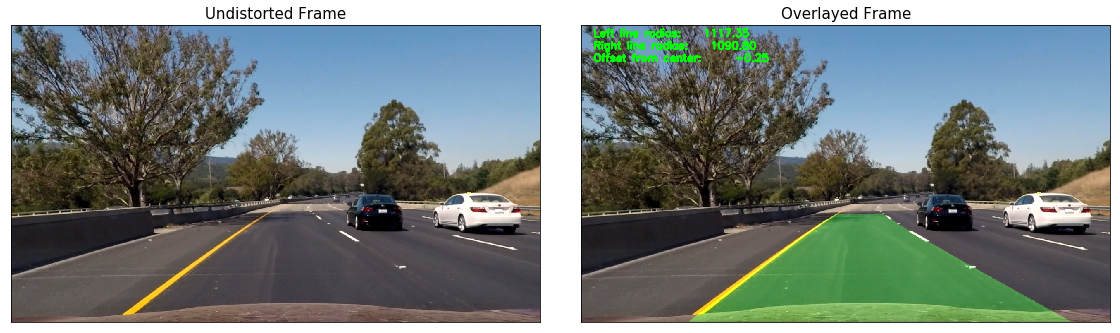

In [14]:
original    = mpimg.imread('./test_images/test6.jpg')
undistorted = cv2.undistort(original, mtx, dist, None, mtx)
filtered    = filter_image(undistorted, show_results=False)
before_warp, after_warp  = warp_image(filtered, draw_line=False)

lanes = LaneTracker()
lanes.detectLanes(after_warp)
overlayed = overlayLane(undistorted, after_warp, lanes)
annotateFrame(overlayed, lanes)

visualize_processed_image(undistorted, overlayed, bTitle='Undistorted Frame', aTitle='Overlayed Frame')

### Final Image Processing Pipeline

In [15]:
def laneFindingPipeline(input_image, mtx, dist, lanes):
    undistorted = cv2.undistort(input_image, mtx, dist, None, mtx)
    filtered    = filter_image(undistorted, show_results=False)
    before_warp, after_warp  = warp_image(filtered, draw_line=False)

    lanes.detectLanes(after_warp)
    overlayed = overlayLane(undistorted, after_warp, lanes)
    annotated = annotateFrame(overlayed, lanes)
    
    return overlayed

### Processing Frames of Video

In [16]:
from moviepy.editor import VideoFileClip

def processVideo(mtx, dist):
    input_video = VideoFileClip('project_video.mp4')
    output_video = 'project_video_result.mp4'
    
    lanes = LaneTracker()
    output = input_video.fl_image(lambda frame: laneFindingPipeline(frame, mtx, dist, lanes))
    output.write_videofile(output_video, audio=False)
    
processVideo(mtx, dist)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [04:35<00:00,  4.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

